# Computing planar potential flows with package `ViscousFlow`

In [1]:
using ViscousFlow

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.1/ViscousFlow/2kdbn.ji for ViscousFlow [103da179-b3e4-57c1-99a4-586354eb2c5a]
└ @ Base loading.jl:1184


In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [3]:
using LinearAlgebra

### First, some generalities

#### First create a grid and a Laplacian operator on it

In [4]:
nx = 128; ny = 128;
Lx = 2.0;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));

In [5]:
L = plan_laplacian(size(w),with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 128, ny = 128) grid with spacing 1.0

#### Now create a circular shape, with discrete points and associated regularization and interpolation operator

In [6]:
n = 196

R = 0.5
body = Ellipse(R,R,n)

# Find the minimum arc length
ds = minimum(Bodies.dlength(body))

# Move the circle
xc = 1.0; yc = 1.0
T = RigidTransform((xc,yc),0.0)
T(body)

Elliptical body with 196 points and semi-axes (0.5,0.5)
   Current position: (1.0,1.0)
   Current angle (rad): 0.0


#### Set up the coordinates and other useful vectors

In [7]:
X = VectorData(body.x,body.y)
f = ScalarData(X);

In [8]:
println("Ratio of arc spacing to cell size = ",ds/dx)

Ratio of arc spacing to cell size = 1.0097544007009378


In [9]:
E = Regularize(X,dx;issymmetric=true)
Hmat,Emat = RegularizationMatrix(E,f,w);

#### And now create the saddle-point system

In [10]:
L⁻¹(w::T) where {T} = L\w
PS = SaddleSystem((w,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true)

Saddle system with 196 constraints and
   State of type Nodes{Dual,128,128}
   Force of type ScalarData{196}


#### Create some data structures for general use

In [11]:
ψb = ScalarData(X)
w = Nodes(Dual,(nx,ny))
ψ = Nodes(Dual,w);

### Solve flow generated by a translating cylinder

In [12]:
ψb .= -(body.x .- body.cent[1])
@time ψ,f = PS\(w,ψb)

  0.010760 seconds (141 allocations: 1.157 MiB)


(Dual nodes in a (nx = 128, ny = 128) cell grid
  Number of Dual nodes: (nx = 128, ny = 128), [-0.0327239, -0.0327071, -0.0326567, -0.0325727, -0.0324552, -0.0323044, -0.0321205, -0.0319035, -0.0316537, -0.0313714  …  -0.0310568, -0.0313714, -0.0316537, -0.0319035, -0.0321205, -0.0323044, -0.0324552, -0.0325727, -0.0326567, -0.0327071])

#### Plot the result

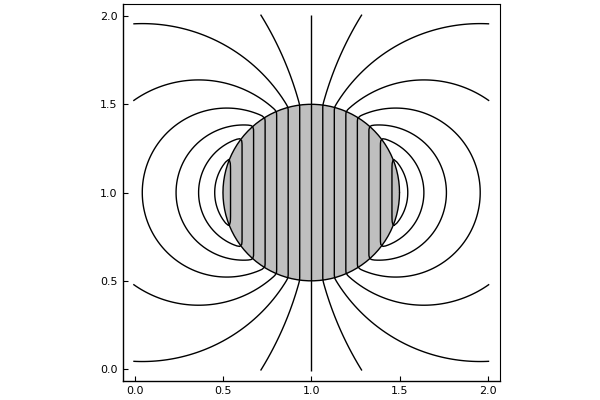

In [13]:
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ,linecolor=:black,levels=range(-1,1,length=31))
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

Plot the result in a frame in which cylinder is stationary

In [14]:
ψtot = Nodes(Dual,ψ)
ψtot .= ψ .+ xg .- body.cent[1]; # adding the free-stream streamfunction

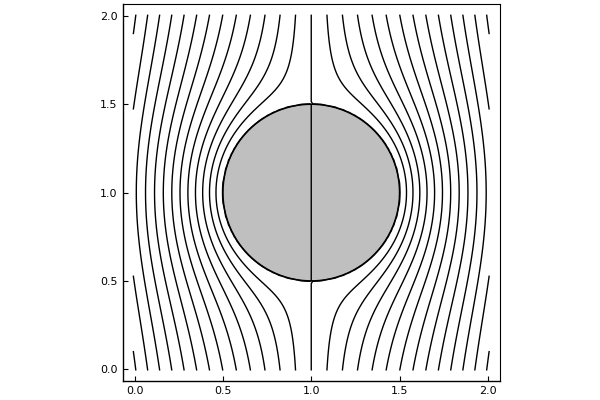

In [15]:
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψtot,linecolor=:black,levels=range(-1,1,length=31))
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

Compare the generated vortex sheet `f/ds` with the exact solution

In [16]:
θ = range(0,2π,length=n+1)
fex = -2*cos.(θ[1:n]);
errinf = LinearAlgebra.norm(f./ds-fex,Inf)

0.04169073409012025

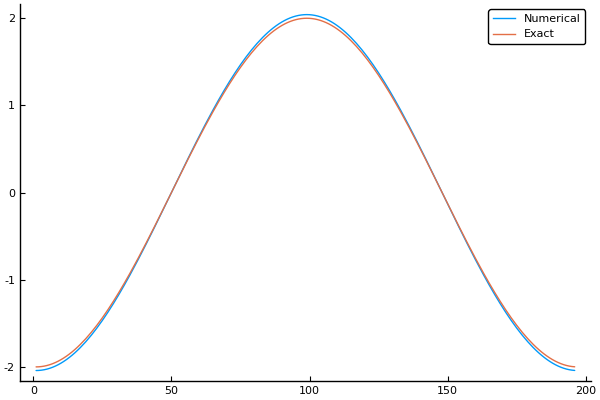

In [17]:
plot(f./ds,label="Numerical")
plot!(fex,label="Exact")

#### Now try storing the Schur matrix

In [18]:
L⁻¹(w::T) where {T} = L\w
PSstore = SaddleSystem((w,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true,store=true)

Saddle system with 196 constraints and
   State of type Nodes{Dual,128,128}
   Force of type ScalarData{196}


This way is significantly faster

  0.002909 seconds (41 allocations: 651.547 KiB)


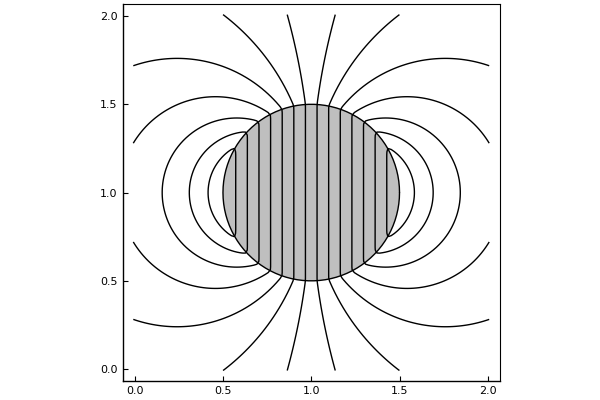

In [19]:
ψb = ScalarData(X);
w = Nodes(Dual,(nx,ny));
ψb .= -(body.x .- body.cent[1]);
f .= ones(Float64,n)*ds;
ψ = Nodes(Dual,w);
@time ψ,f = PSstore\(w,ψb)
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ,linecolor=:black)
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

But there is significantly more noise in the force

In [20]:
fex = -2*cos.(θ[1:n]);
errinf = norm(f./ds-fex,Inf)

0.22863517181933357

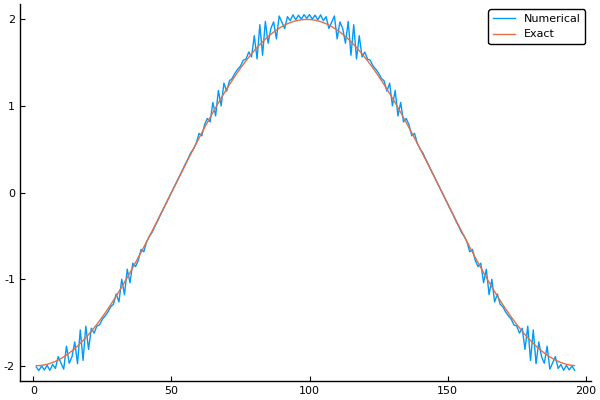

In [21]:
plot(f./ds,label="Numerical")
plot!(fex,label="Exact")

So let's filter it

In [22]:
Ẽ = Regularize(X,dx;weights=ds,filter=true)
H̃mat = RegularizationMatrix(Ẽ,f,w);
Ẽmat = InterpolationMatrix(Ẽ,w,f);

In [23]:
f̃ = ScalarData(X);

In [24]:
P(f) = Ẽmat*(H̃mat*f)
PScond = SaddleSystem((w,f̃),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true,conditioner=P,store=true)

Saddle system with 196 constraints and
   State of type Nodes{Dual,128,128}
   Force of type ScalarData{196}


  0.002854 seconds (46 allocations: 779.672 KiB)


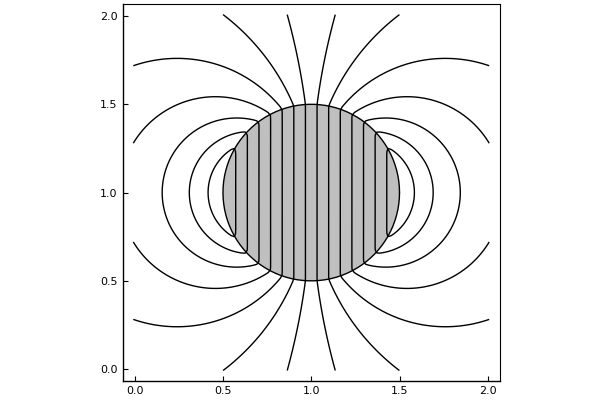

In [25]:
ψb = ScalarData(X);
w = Nodes(Dual,(nx,ny));
ψb .= -(body.x .- body.cent[1]);
ψ = Nodes(Dual,w);
@time ψ,f̃ = PScond\(w,ψb)
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ,linecolor=:black)
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

In [26]:
fex = -2*cos.(θ[1:n]);
errinf = norm(f̃./ds-fex,Inf)

0.05299531155649628

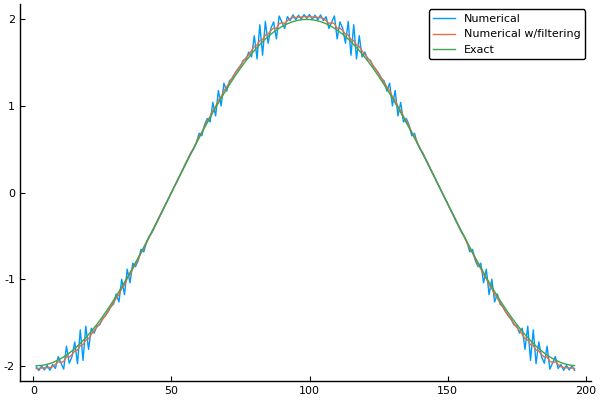

In [27]:
plot(f./ds,label="Numerical")
plot!(f̃./ds,label="Numerical w/filtering")
plot!(fex,label="Exact")

### Now flow about a cylinder with net circulation

#### Set up some helpful operators

`oB` is the basis vector for uniform Lagrange point data. As a transpose, it is a summation operator on Lagrange point data.

In [28]:
oB = zeros(size(f))
oB .= 1;

`S` is a matrix form of the Schur complement,

$$S = -EL^{-1}H$$

In [29]:
S = Matrix(PS.S);

`T` is a modified version of the Schur complement. Note that the operator

$$S^{-1}T S^{-1} = S^{-1}\left(S - \frac{o_B^T o_B}{o_B^T S^{-1} o_B} \right) S^{-1}$$

is identically zero when it acts upon uniform Lagrange point data. It produces the influence of the variable part of Lagrange point data on the vortex sheet strength.

In [30]:
S₀ = transpose(oB)*(S\oB)
T = S - oB*transpose(oB)/S₀;

#### Now set the problem parameters

In [31]:
# The desired streamfunction on the circle surface
ψb .= 1

# The desired circulation about the circle
Γ0 = 1;

#### Compute the vortex sheet strength

As mentioned above, the first term is actually zero when $\psi_b$ is uniform. So this sheet strength is entirely due to the desired circulation, distributed uniformly on the surface.

In [32]:
f .= S\(T*(S\ψb) .+ Γ0*oB/S₀);

#### Check that this `f` gives correct circulation

In [33]:
sum(f)

0.9999999999999996

#### Now the streamfunction

Here, we compute the uniform streamfunction. We first cancel the circulation due to the vortex sheet (attributable to the desired circulation), and then we add the desired streamfunction on the circle.

In [34]:
ψ₀ = -1/S₀*(Γ0 - transpose(oB)*(S\ψb))

1.5507044895456807

The overall streamfunction is due to the field induced by the vortex sheet and to the uniform value. 

In [35]:
ψ .= -(L\(Hmat*f)) .+ ψ₀;

In [36]:
q = curl(ψ)/dx;

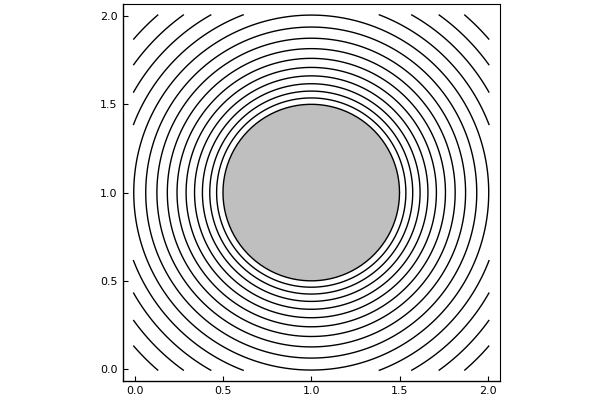

In [37]:
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ,linecolor=:black)
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

#### Plot the vertical velocity along a horizontal line

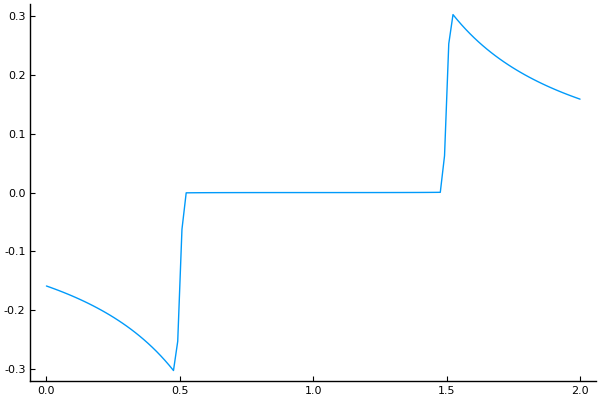

In [38]:
jcent = ny ÷ 2
xu,yu = coordinates(q.v,dx=dx)
plot(xu,q.v[:,jcent],legend=:false)

#### Plot the streamfunction along a horizontal line

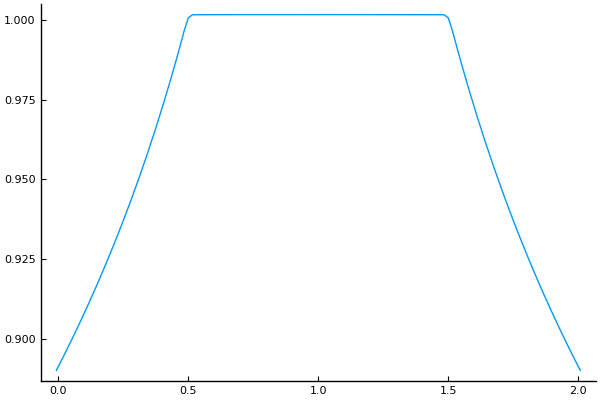

In [39]:
jcent = ny ÷ 2
plot(xg,ψ[:,jcent],legend=:false)

### Now flow about another shape with net circulation

In [40]:
body = Rectangle(1.0,1.0,63)

# Find the minimum arc length
ds = minimum(Bodies.dlength(body))

# Move the shape
xc = 1.0; yc = 1.0
T = RigidTransform((xc,yc),0.0)
T(body)

Rectangular body with 252 points, length 1.0 and width 1.0)
   Current position: (1.0,1.0)
   Current angle (rad): 0.0


In [41]:
X = VectorData(body.x,body.y)
f = ScalarData(X);

In [42]:
println("Ratio of arc spacing to cell size = ",ds/dx)

Ratio of arc spacing to cell size = 0.9999999999999964


In [43]:
E = Regularize(X,dx;issymmetric=true)
Hmat,Emat = RegularizationMatrix(E,f,w);

#### And now create the saddle-point system

In [44]:
L⁻¹(w::T) where {T} = L\w
PS = SaddleSystem((w,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true)

Saddle system with 252 constraints and
   State of type Nodes{Dual,128,128}
   Force of type ScalarData{252}


#### Create some data structures for general use

In [45]:
ψb = ScalarData(X);
w = Nodes(Dual,(nx,ny));
ψ = Nodes(Dual,w)
f = ScalarData(X);

In [46]:
oB = zeros(size(f))
oB .= 1;

`S` is a matrix form of the Schur complement,

$$S = -EL^{-1}H$$

In [47]:
S = Matrix(PS.S);

`T` is a modified version of the Schur complement. Note that the operator

$$S^{-1}T S^{-1} = S^{-1}\left(S - \frac{o_B^T o_B}{o_B^T S^{-1} o_B} \right) S^{-1}$$

is identically zero when it acts upon uniform Lagrange point data. It produces the influence of the variable part of Lagrange point data on the vortex sheet strength.

In [48]:
S₀ = transpose(oB)*(S\oB)
T = S - oB*transpose(oB)/S₀;

#### Now set the problem parameters

In [49]:
# The desired streamfunction on the circle surface
ψb .= -(body.x .- body.cent[1]); # Translation in y direction

# The desired circulation about the circle
Γ0 = 1;

#### Compute the vortex sheet strength

As mentioned above, the first term is actually zero when $\psi_b$ is uniform. So this sheet strength is entirely due to the desired circulation, distributed uniformly on the surface.

In [50]:
f .= S\(T*(S\ψb) .+ Γ0*oB/S₀);

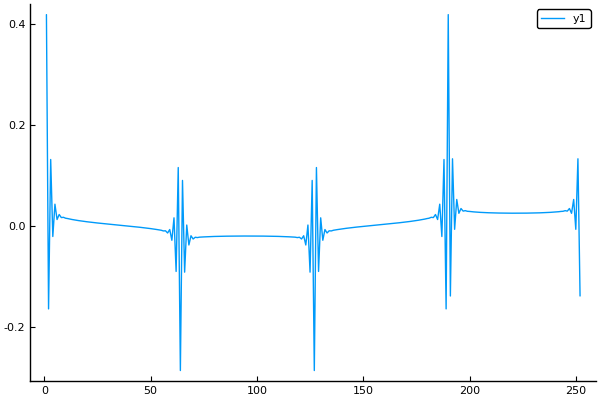

In [51]:
plot(f)

#### Check that this `f` gives correct circulation

In [52]:
sum(f)

1.0

#### Now the streamfunction

Here, we compute the uniform streamfunction. We first cancel the circulation due to the vortex sheet (attributable to the desired circulation), and then we add the desired streamfunction on the circle.

In [53]:
ψ₀ = -1/S₀*(Γ0 - transpose(oB)*(S\ψb))

0.5775613969647341

The overall streamfunction is due to the field induced by the vortex sheet and to the uniform value. 

In [54]:
ψ .= -(L\(Hmat*f)) .+ ψ₀;

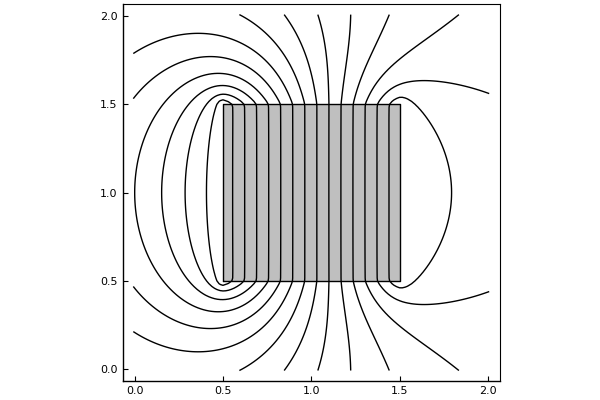

In [55]:
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ,linecolor=:black)
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

### Let's try an airfoil

In [56]:
?NACA4

search: NACA4 plan_laplacian plan_laplacian!



```
NACA4(cam,pos,thick[;np=20][,Xc=(0.0,0.0)][,len=1.0]) <: Body{N}
```

Generates points in the shape of a NACA 4-digit airfoil of chord length 1. The relative camber is specified by `cam`, the position of maximum camber (as fraction of chord) by `pos`, and the relative thickness by `thick`.

The optional parameter `np` specifies the number of points on the upper or lower surface. The optional parameter `Zc` specifies the mean position of the vertices (which is set to the origin by default). The optional parameter `len` specifies the chord length.

# Example

```jldoctest
julia> w = Bodies.NACA4(0.0,0.0,0.12);
```


In [57]:
c = 1.0
body = NACA4(0.0,0.0,0.12,np=98,len=c)

# Find the minimum arc length
ds = maximum(Bodies.dlength(body))

# Move the shape
xc = 1.0; yc = 1.0
α = 20π/180
T = RigidTransform((xc,yc),-α)
T(body)

NACA 4-digit airfoil with 195 points and length 1.0 and thickness 0.12
   Current position: (1.0,1.0)
   Current angle (rad): -0.3490658503988659


In [58]:
X = VectorData(body.x,body.y)
f = ScalarData(X);

In [59]:
println("Ratio of arc spacing to cell size = ",ds/dx)

Ratio of arc spacing to cell size = 0.940712105158888


In [60]:
E = Regularize(X,dx;issymmetric=true)
Hmat,Emat = RegularizationMatrix(E,f,w);

#### And now create the saddle-point system

In [61]:
L⁻¹(w::T) where {T} = L\w
PS = SaddleSystem((w,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true)

Saddle system with 195 constraints and
   State of type Nodes{Dual,128,128}
   Force of type ScalarData{195}


#### Create some data structures for general use

In [62]:
ψb = ScalarData(X);
w = Nodes(Dual,(nx,ny));
ψ = Nodes(Dual,w)
f = ScalarData(X);

In [63]:
oB = zeros(size(f))
oB .= 1;

`S` is a matrix form of the Schur complement,

$$S = -EL^{-1}H$$

In [64]:
S = Matrix(PS.S);

`T` is a modified version of the Schur complement. Note that the operator

$$S^{-1}T S^{-1} = S^{-1}\left(S - \frac{o_B^T o_B}{o_B^T S^{-1} o_B} \right) S^{-1}$$

is identically zero when it acts upon uniform Lagrange point data. It produces the influence of the variable part of Lagrange point data on the vortex sheet strength.

In [65]:
S₀ = transpose(oB)*(S\oB)
T = S - oB*transpose(oB)/S₀;

#### Now set the problem parameters

In [74]:
# free stream
U∞ = 1

# The desired streamfunction on the circle surface
ψb .= -U∞*(body.y .- body.cent[2]) # Translation in x direction

# The desired circulation about the circle
Γ0 = -π*c*U∞*sin(α)

-1.074487969651649

#### Compute the vortex sheet strength

As mentioned above, the first term is actually zero when $\psi_b$ is uniform. So this sheet strength is entirely due to the desired circulation, distributed uniformly on the surface.

In [75]:
f .= S\(T*(S\ψb) .+ Γ0*oB/S₀);

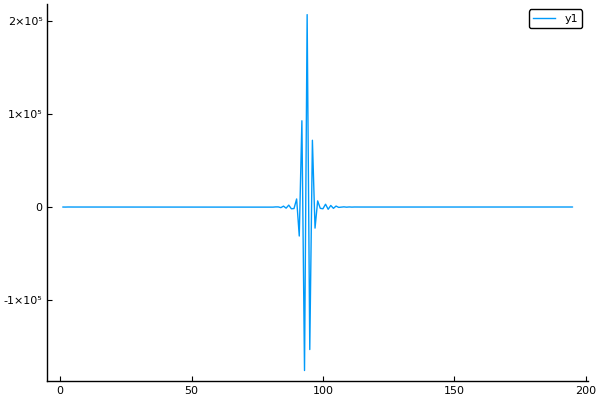

In [76]:
plot(f)

#### Now the streamfunction

Here, we compute the uniform streamfunction. We first cancel the circulation due to the vortex sheet (attributable to the desired circulation), and then we add the desired streamfunction on the circle.

In [77]:
ψ₀ = -1/S₀*(Γ0 - transpose(oB)*(S\ψb))

-0.4798331750057964

The overall streamfunction is due to the field induced by the vortex sheet and to the uniform value. 

In [78]:
ψ .= -(L\(Hmat*f)) .+ ψ₀;

In [79]:
ψtot = Nodes(Dual,ψ)
ψtot .= ψ .+ yg' .- body.cent[2]; # adding the free-stream streamfunction

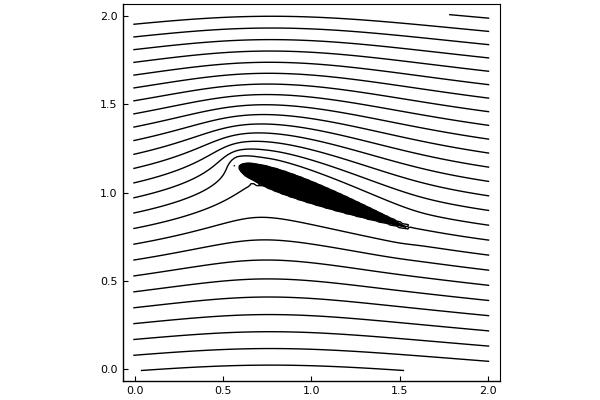

In [81]:
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψtot,linecolor=:black,levels=31)
plot!(body,fillcolor=:black,fillrange=0,fillalpha=1,linecolor=:black)

-17.5

In [83]:
(-40-5)/2

-22.5

In [85]:
-22.5+17.5

-5.0